In [33]:
import sys
from sasmodels import core
from sasmodels import direct_model
from sasmodels.resolution import Resolution, Pinhole1D, Slit1D, romberg_pinhole_1d, romberg_slit_1d
import matplotlib.pyplot as plt  # type: ignore
import numpy as np


In [ ]:
def apply_resolution_matrix(weight_matrix, theory):
    """
    Apply the resolution weight matrix to the computed theory function.
    """
    #print("apply shapes", theory.shape, weight_matrix.shape)
    Iq = np.dot(theory[None, :], weight_matrix)
    #print("result shape",Iq.shape)
    return Iq.flatten()

class Generic1D(Resolution):
    """
    Generic resolution function using weighted matrix input
    """
    def __init__(self, q):
        self.q_calc = self.q = q
        
        #Load this from file/data
        self.weight_matrix = load_from_file()
        

    def apply(self, theory):
        return apply_resolution_matrix(self.weight_matrix, theory)

In [34]:
def _eval_demo_1d(resolution, name, title):

    if name == 'cylinder':
        pars = {'length':210, 'radius':500, 'background': 0}
    elif name == 'teubner_strey':
        pars = {'a2':0.003, 'c1':-1e4, 'c2':1e10, 'background':0.312643}
    elif name in ('sphere', 'spherepy'):
        pars = TEST_PARS_SLIT_SPHERE
    elif name == 'ellipsoid':
        pars = {
            'scale':0.05, 'background': 0,
            'r_polar':500, 'r_equatorial':15000,
            'sld':6, 'sld_solvent': 1,
            }
    else:
        pars = {}
    model_info = core.load_model_info(name)
    model = core.build_model(model_info)

    kernel = model.make_kernel([resolution.q_calc])
    theory = direct_model.call_kernel(kernel, pars)
    Iq = resolution.apply(theory)

    if isinstance(resolution, Slit1D):
        width, height = resolution.qx_width, resolution.qy_width
        Iq_romb = romberg_slit_1d(resolution.q, width, height, model, pars)
    else:
        dq = resolution.q_width
        Iq_romb = romberg_pinhole_1d(resolution.q, dq, model, pars)

   
    plt.loglog(resolution.q_calc, theory, label='unsmeared')
    plt.loglog(resolution.q, Iq, label='smeared')
    plt.loglog(resolution.q, Iq_romb, label='romberg smeared')
    plt.legend()
    plt.title(title)
    plt.xlabel("Q (1/Ang)")
    plt.ylabel("I(Q) (1/cm)")

In [35]:
def demo_pinhole_1d(name):
    """
    Show example of pinhole smearing.
    """
    q = np.logspace(-4, np.log10(0.2), 400)
    q_width = 0.1*q
    resolution = Pinhole1D(q, q_width)
    _eval_demo_1d(resolution, name, title="10% dQ/Q Pinhole Resolution")

def demo_slit_1d(name):
    """
    Show example of slit smearing.
    """
    q = np.logspace(-4, np.log10(0.2), 100)
    w = h = 0.
    #w = 0.000000277790
    w = 0.0277790
    #h = 0.00277790
    #h = 0.0277790
    resolution = Slit1D(q, w, h)
    _eval_demo_1d(resolution, name, title="(%g,%g) Slit Resolution"%(w, h))

    
def demo_generic_resolution(name):
    """
    Show example of slit smearing.
    """
    q = np.logspace(-4, np.log10(0.2), 100)
    #De
    resolution = Slit1D(q, w, h)
    _eval_demo_1d(resolution, name, title="(%g,%g) Slit Resolution"%(w, h))

def demo(name):
    """
    Run the resolution demos.
    """
    plt.subplot(121)
    demo_pinhole_1d(name)
    #plt.yscale('linear')
    plt.subplot(122)
    demo_slit_1d(name)
    #plt.yscale('linear')
    plt.show()

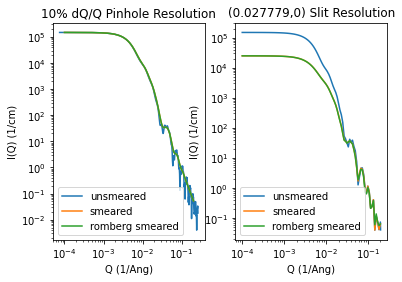

In [36]:
name = 'cylinder'
demo(name)